In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Path to your dataset folder
dataset_path = '/content/drive/MyDrive/Indian-monuments'


In [ ]:
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

path = "/content/drive/MyDrive/Indian-monuments/images"
for dirpath, dirnames, filenames in os.walk(path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Num GPUs Available:  1
There are 2 directories and 0 images in '/content/drive/MyDrive/Indian-monuments/images'.
There are 24 directories and 0 images in '/content/drive/MyDrive/Indian-monuments/images/test'.
There are 0 directories and 36 images in '/content/drive/MyDrive/Indian-monuments/images/test/alai_darwaza'.
There are 0 directories and 30 images in '/content/drive/MyDrive/Indian-monuments/images/test/basilica_of_bom_jesus'.
There are 0 directories and 34 images in '/content/drive/MyDrive/Indian-monuments/images/test/Ellora Caves'.
There are 0 directories and 34 images in '/content/drive/MyDrive/Indian-monuments/images/test/Charar-E- Sharif'.
There are 0 directories and 30 images in '/content/drive/MyDrive/Indian-monuments/images/test/Gateway of India'.
There are 0 directories and 40 images in '/content/drive/MyDrive/Indian-monuments/images/test/charminar'.
There are 0 directories and 31 images in '/content/drive/MyDrive/Indian-monuments/images/test/Ajanta Caves'.
There are 0 di

In [ ]:

train_dir =  path + "/train/"
test_dir = path + "/test/"
train_dir

'/content/drive/MyDrive/Indian-monuments/images/train/'

In [ ]:

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['Ajanta Caves', 'Charar-E- Sharif', 'Chhota_Imambara',
       'Ellora Caves', 'Fatehpur Sikri', 'Gateway of India',
       'Humayun_s Tomb', 'India gate pics', 'Khajuraho',
       'Sun Temple Konark', 'alai_darwaza', 'alai_minar',
       'basilica_of_bom_jesus', 'charminar', 'golden temple',
       'hawa mahal pics', 'iron_pillar', 'jamali_kamali_tomb',
       'lotus_temple', 'mysore_palace', 'qutub_minar', 'tajmahal',
       'tanjavur temple', 'victoria memorial'], dtype='<U21')

In [ ]:

def view_random_image(target_dir, target_class):
    target_folder = target_dir  + target_class


    random_image = random.sample(os.listdir(target_folder), 1)


    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))


  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Image shape: (408, 612, 3)


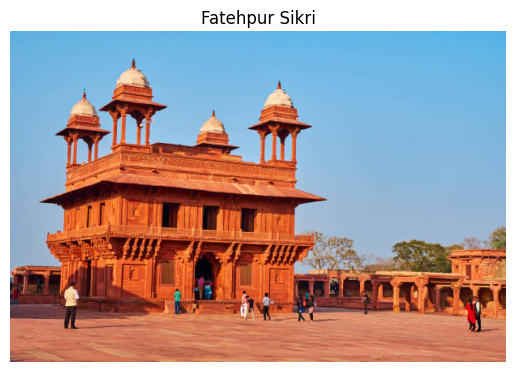

In [ ]:

import random
img = view_random_image(target_dir=train_dir, target_class=random.choice(class_names))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)


train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(300, 300),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(300, 300),
                                              batch_size=32,
                                              class_mode='categorical')

Found 3695 images belonging to 24 classes.
Found 1049 images belonging to 24 classes.


In [ ]:

model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(300, 300, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(24, activation='softmax')
])

In [ ]:
model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=50,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/50
  2/116 ━━━━━━━━━━━━━━━━━━━━ 19:25 10s/step - accuracy: 0.0703 - loss: 3.7634

KeyboardInterrupt: 

In [ ]:

def load_and_prep_image(filename, img_shape=300):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.

  return img

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """

  img = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
model_10 = load_model('/content/drive/MyDrive/Colab Notebooks/my_combined_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


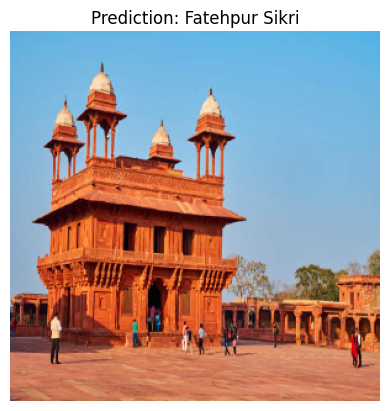

In [ ]:
pred_and_plot(model_10, "/content/drive/MyDrive/Indian-monuments/images/test/Fatehpur Sikri/13.jpg", class_names)


In [ ]:
model_save_path = "/content/drive/MyDrive/saved_models"
import os
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
#RESNET 50

In [ ]:
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Set up paths
train_dir = "/content/drive/MyDrive/Indian-monuments/images/train"
test_dir = "/content/drive/MyDrive/Indian-monuments/images/test"

# Load class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
num_classes = len(class_names)

# ImageDataGenerators (already normalized)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(300, 300),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(300, 300),
                                             batch_size=32,
                                             class_mode='categorical')

# Load the ResNet50 base model
base_model = ResNet50(include_top=False,
                      weights='imagenet',
                      input_shape=(300, 300, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
inputs = Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs, outputs)

# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=10,  # Start with 10 epochs, fine-tune later
                                  validation_data=test_data)

# Optional: Fine-tune the top layers of ResNet
base_model.trainable = True
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(1e-5),  # Low learning rate for fine-tuning
                     metrics=['accuracy'])

history_finetuned = resnet_model.fit(train_data,
                                     epochs=10,  # Further training
                                     validation_data=test_data)


Found 3695 images belonging to 24 classes.
Found 1049 images belonging to 24 classes.
Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 77s 577ms/step - accuracy: 0.0715 - loss: 3.2096 - val_accuracy: 0.0705 - val_loss: 3.2083
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 463ms/step - accuracy: 0.1199 - loss: 3.0132 - val_accuracy: 0.0877 - val_loss: 3.1913
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 57s 487ms/step - accuracy: 0.1218 - loss: 2.9824 - val_accuracy: 0.0934 - val_loss: 3.2358
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 55s 475ms/step - accuracy: 0.1753 - loss: 2.8940 - val_accuracy: 0.0763 - val_loss: 3.1380
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 65s 563ms/step - accuracy: 0.1662 - loss: 2.8227 - val_accuracy: 0.1010 - val_loss: 3.1140
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 55s 474ms/step - accuracy: 0.1951 - loss: 2.7704 - val_accuracy: 0.0877 - val_loss: 3.0550
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 467ms/step - accuracy: 0.2257 - loss: 2.7331 - val_accuracy: 0.1706 - val_loss: 3.07

In [ ]:
def plot_loss_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


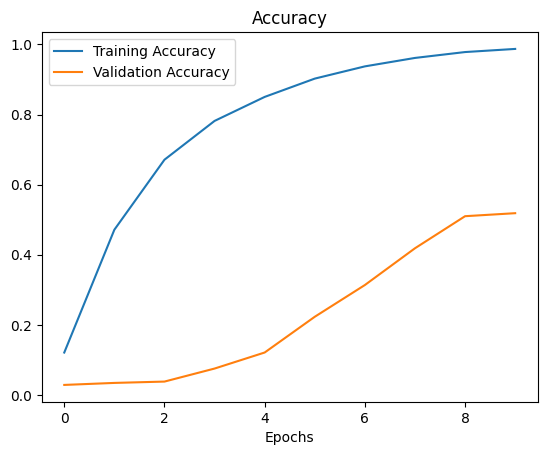

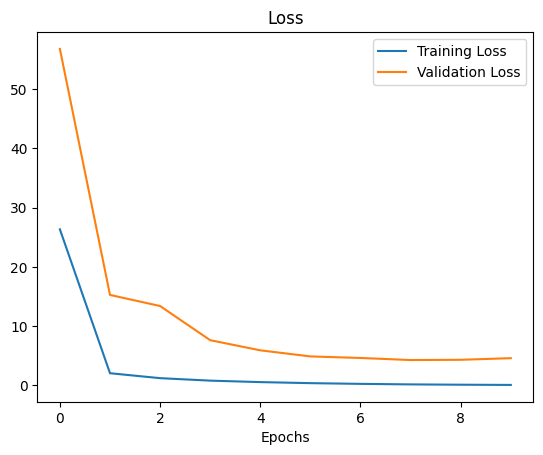

In [ ]:
plot_loss_curves(history_finetuned)



In [ ]:
# Save model to Google Drive
resnet_model.save('/content/drive/MyDrive/Colab Notebooks/my_resnet_model.h5')
print("Model saved to Google Drive.")



Model saved to Google Drive.


In [ ]:
def load_and_prep_image(filename, img_shape=300):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = img / 255.
    return img

def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()]
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


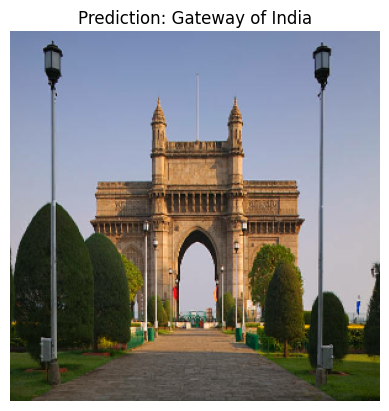

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_loaded = load_model('/content/drive/MyDrive/Colab Notebooks/my_resnet_model.h5')

# Test with an image
test_image_path = "/content/drive/MyDrive/Indian-monuments/images/test/Gateway of India/142.jpg"
pred_and_plot(model_loaded, test_image_path, class_names)


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks"


In [ ]:
from google.colab import files

# This opens a file dialog in Colab to upload from your computer
uploaded = files.upload()


Saving ajanta-caves-aurangabad-tourism-entry-fee-timings-holidays-reviews-header.jpg to ajanta-caves-aurangabad-tourism-entry-fee-timings-holidays-reviews-header.jpg


In [ ]:
# Get the uploaded filename
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)


Uploaded file: ajanta-caves-aurangabad-tourism-entry-fee-timings-holidays-reviews-header.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


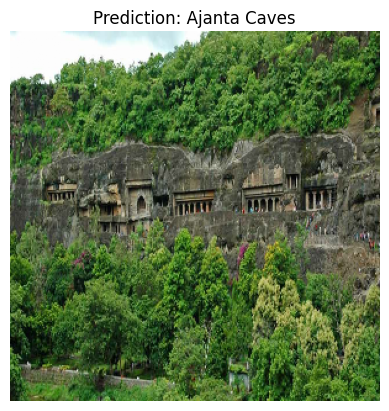

In [ ]:
pred_and_plot(model_loaded, filename, class_names)
